# Initial Setup

In [1]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

print(tf.__version__)

2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Imagenet Subset 

In [3]:
dataDir = '/data/datasets/cifar100/raw'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'models/cifar100_resnet50_adam_v4'
logsDir = 'logs/cifar100_resnet50_adam_v4'

In [4]:
BATCH_SIZE = 128
NUM_EPOCHS = 200
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 100
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [5]:
if not os.path.exists(configDir):
  os.makedirs(configDir)

if not os.path.exists(resultsDir):
  os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
  os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
  os.makedirs(logsDir)

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [8]:
def rotate_tf(image, angle):
    angleRad = angle/180.*np.pi
  
    if image.shape.__len__() ==4:
            
        random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
    if image.shape.__len__() ==3:
        random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
    
    paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
    img = tf.pad(image, paddings, "SYMMETRIC")
    img = tfa.image.rotate(img, random_angles)
    img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT, IMG_WIDTH)

    return img

def augment(image, label):
    #img = tf.image.rot90(image)
    img = tf.image.flip_left_right(image)
    img = rotate_tf(image, 20)
    #img = tf.image.random_brightness(img, 0.05)
    #img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return (img, label)
  
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
              
  # Repeat forever
  #ds = ds.repeat()
  
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [9]:
meta = unpickle(os.path.join(dataDir, 'meta'))
train = unpickle(os.path.join(dataDir, 'train'))
test = unpickle(os.path.join(dataDir, 'test'))

In [10]:
classDF = pd.DataFrame(meta[b'fine_label_names'], columns = ['Classes'], dtype=str)
CLASS_NAMES = np.array(classDF['Classes'])

In [11]:
trainX = np.vstack(train[b"data"])
trainX = trainX.reshape(len(trainX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
trainY = train[b'fine_labels']
trainY = tf.one_hot(trainY, NUM_CLASSES)

testX = np.vstack(test[b"data"])
testX = testX.reshape(len(testX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
testY = test[b'fine_labels']
testY = tf.one_hot(testY, NUM_CLASSES)

In [12]:
print(trainX.shape)
print(testX.shape)

print(trainY.shape)
print(testY.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 100)
(10000, 100)


In [13]:
trainLabelDS = tf.data.Dataset.from_tensor_slices((trainX, trainY))
valLabelDS = tf.data.Dataset.from_tensor_slices((testX, testY))

In [14]:
trainDS = prepare_for_training(trainLabelDS)
valDS = prepare_for_validation(valLabelDS)

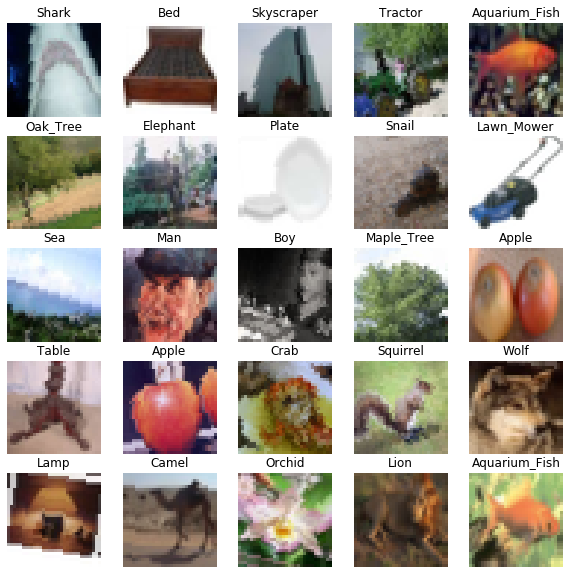

In [15]:
image_batch, label_batch = next(iter(trainDS))
show_batch(image_batch.numpy(), label_batch.numpy())

## Create model

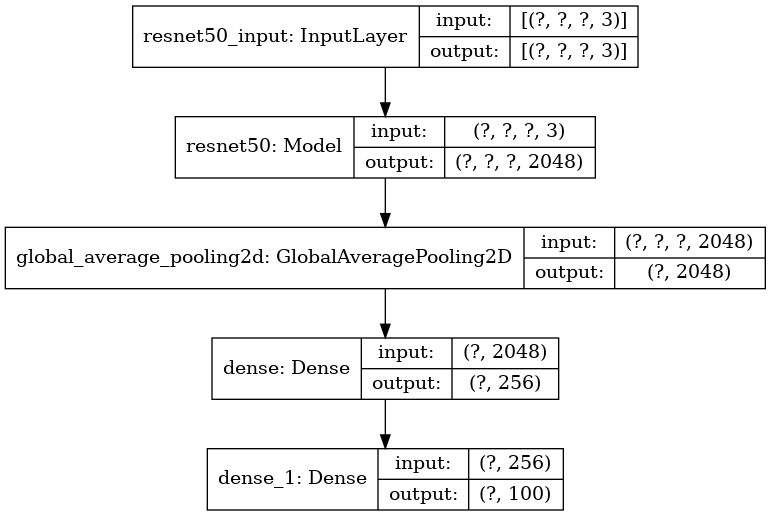

In [16]:
modelDiagramFile = os.path.join(resultsDir, 'model_resnet50_imagenet.png')

resnet50 = tf.keras.applications.ResNet50(weights=None, include_top=False)
model = tf.keras.Sequential([resnet50, layers.GlobalAveragePooling2D(), layers.Dense(256, activation='relu'), layers.Dense(NUM_CLASSES, activation='softmax')])

keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)

## Train model

In [17]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
        
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    print('Learning rate: ', lr)
    return lr

In [18]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logsCheckDir + "/metrics")
file_writer.set_as_default()

tb_callback = keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1)
ck_callback = keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5"))
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

callbacks = [tb_callback, ck_callback, lr_callback]

optimizer = tf.optimizers.Adam(learning_rate=lr_schedule(0))

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Learning rate:  0.001


In [19]:
startTime = time.time()

model.fit(trainDS,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          validation_data=valDS,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Learning rate:  0.001
Epoch 1/200
391/391 [==============================] - 24s 62ms/step - loss: 4.2511 - accuracy: 0.0520 - val_loss: 4.5928 - val_accuracy: 0.0478 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
391/391 [==============================] - 23s 59ms/step - loss: 3.7687 - accuracy: 0.1124 - val_loss: 4.3033 - val_accuracy: 0.0938 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
391/391 [==============================] - 23s 58ms/step - loss: 3.4585 - accuracy: 0.1651 - val_loss: 3.4442 - val_accuracy: 0.1780 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
391/391 [==============================] - 23s 58ms/step - loss: 3.2265 - accuracy: 0.2080 - val_loss: 4.7152 - val_accuracy: 0.1009 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
391/391 [==============================] - 23s 58ms/step - loss: 3.1221 - accuracy: 0.2271 - val_loss: 3.7838 - val_accuracy: 0.1582 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
391/391 [==============================] - 23s 58ms/step - loss: 2

KeyboardInterrupt: 